In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [103]:
# Load and preprocess data
df = pd.read_csv('/content/pamap2_HAR_raw.csv')
df = df.head(25000)

In [104]:
# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

In [105]:
# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

In [106]:
# Min-Max Scaling
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

In [107]:
# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
sensor_data_scaled['activityID'] = df['activityID']
sensor_data_scaled['activity_name'] = df['activity_name']

In [108]:
# Train-Test Split (80% train, 20% test)
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])

In [109]:
# Create sequences for LSTM input
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

In [110]:
# Define LSTM Autoencoder
class LSTMAutoencoder(Model):
    def __init__(self, input_shape):
        super(LSTMAutoencoder, self).__init__()
        self.encoder_lstm1 = LSTM(128, activation='relu', return_sequences=True)
        self.encoder_lstm2 = LSTM(64, activation='relu', return_sequences=False)
        self.decoder_repeat = RepeatVector(input_shape[0])
        self.decoder_lstm1 = LSTM(64, activation='relu', return_sequences=True)
        self.decoder_lstm2 = LSTM(128, activation='relu', return_sequences=True)
        self.decoder_dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs):
        encoded = self.encoder_lstm1(inputs)
        encoded = self.encoder_lstm2(encoded)
        decoded = self.decoder_repeat(encoded)
        decoded = self.decoder_lstm1(decoded)
        decoded = self.decoder_lstm2(decoded)
        decoded = self.decoder_dense(decoded)
        decoded = self.reshape_layer(decoded)
        return decoded

# Initialize and compile model
seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = LSTMAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

In [111]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 101ms/step - loss: 0.0201
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 111ms/step - loss: 2.7685e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 101ms/step - loss: 2.0903e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 110ms/step - loss: 1.6770e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 104ms/step - loss: 1.6174e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step - loss: 1.7137e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - loss: 1.4269e-04
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - loss: 1.4335e-04
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 109ms/step - loss: 1.3245e-04
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 1.3239e-04


In [112]:
# Function to Compute Anomaly-Based Rewards
def compute_unsupervised_rewards(X):
    reconstructed = autoencoder.predict(X)
    reconstruction_error = np.mean(np.abs(X - reconstructed), axis=2)
    threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)
    rewards = (reconstruction_error > threshold).astype(int)
    return rewards

# Generate Rewards
unsupervised_rewards = compute_unsupervised_rewards(X_train)
unsupervised_rewards = np.expand_dims(unsupervised_rewards, axis=-1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step


In [113]:
# Define PPO Agent
class PPOAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(PPOAgent, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.policy_logits = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.policy_logits(x)

In [114]:
# Instantiate PPO Agent
num_actions = 2
ppo_model = PPOAgent(num_actions)

In [115]:
# Define PPO Trainer
class PPOTrainer:
    def __init__(self, model, gamma=0.99, learning_rate=0.0001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def train(self, X, rewards, epochs=10):
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                logits = self.model(X)
                policy_out = tf.nn.softmax(logits)
                rewards = np.where(rewards > 0, 1, 0).astype(int)
                rewards = rewards.reshape(rewards.shape[0], rewards.shape[1])
                action_probs = tf.reduce_sum(policy_out * tf.one_hot(rewards, depth=2), axis=-1)
                loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-10) * tf.cast(rewards, tf.float32))
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

In [116]:
# Train PPO Model
ppo_trainer = PPOTrainer(ppo_model)
ppo_trainer.train(X_train, unsupervised_rewards, epochs=10)

Epoch 1/10, Loss: 0.0270
Epoch 2/10, Loss: 0.0266
Epoch 3/10, Loss: 0.0262
Epoch 4/10, Loss: 0.0258
Epoch 5/10, Loss: 0.0254
Epoch 6/10, Loss: 0.0250
Epoch 7/10, Loss: 0.0246
Epoch 8/10, Loss: 0.0242
Epoch 9/10, Loss: 0.0238
Epoch 10/10, Loss: 0.0234


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


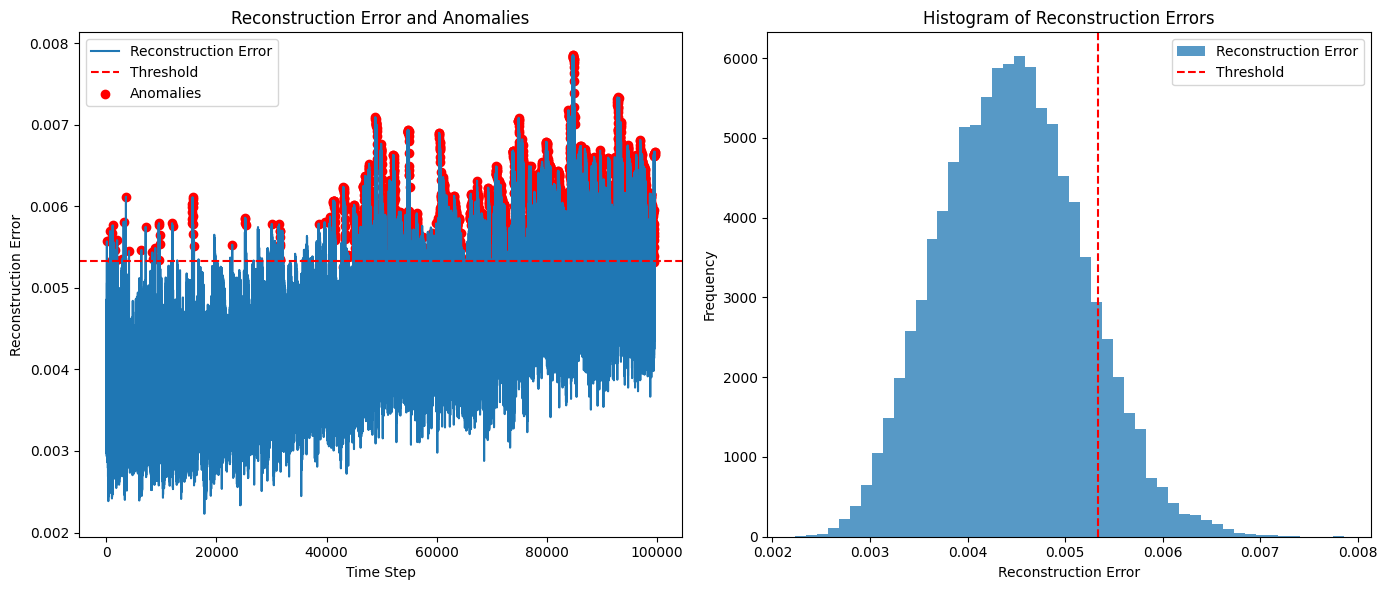

Total number of anomalies detected: 4980
Indices of anomalous points: [  120   700   760 ... 99551 99570 99589]
Reconstruction errors of anomalous points: [0.00556946 0.00569691 0.00558806 ... 0.00666934 0.00662829 0.00664445]


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute reconstruction error for the test set
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

# Compute the threshold for anomalies
threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

# Identify anomalies
anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

# Plot reconstruction error and anomalies
plt.figure(figsize=(14, 6))

# Plot reconstruction error
plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

# Plot histogram of reconstruction errors
plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()

plt.tight_layout()
plt.show()

# Print total number of anomalies
print(f"Total number of anomalies detected: {total_anomalies}")

# Print details of points marked as anomalous
anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])